# Anomaly Detection

## Packages

In [7]:
import numpy as np
import pandas as pd
import os, time
import pickle, gzip
 
""" visualization """
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

""" Data Prep and Model Evaluation"""
from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from numpy.testing import assert_array_almost_equal
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

"""Algos"""
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

## Fraud Detection

In [8]:
data = pd.read_csv("https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv")

In [9]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [10]:
dataX = data.copy().drop(['Class'], axis=1)
dataY = data['Class'].copy()

In [11]:
dataX.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [12]:
dataX.shape

(284807, 30)

In [13]:
dataY.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [14]:
dataX.skew()

Time      -0.035568
V1        -3.280667
V2        -4.624866
V3        -2.240155
V4         0.676292
V5        -2.425901
V6         1.826581
V7         2.553907
V8        -8.521944
V9         0.554680
V10        1.187141
V11        0.356506
V12       -2.278401
V13        0.065233
V14       -1.995176
V15       -0.308423
V16       -1.100966
V17       -3.844914
V18       -0.259880
V19        0.109192
V20       -2.037155
V21        3.592991
V22       -0.213258
V23       -5.875140
V24       -0.552499
V25       -0.415793
V26        0.576693
V27       -1.170209
V28       11.192091
Amount    16.977724
dtype: float64

let's scale these things 

In [15]:
sX = pp.StandardScaler(copy=True)
featuresToScale = dataX.columns
dataX.loc[:, featuresToScale] = sX.fit_transform(dataX[featuresToScale])

hold-out

In [16]:
X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.33, random_state=2018, stratify=dataY)

### Define Anomaly Score Function

Since fraud is rare and presumably different than normal transactions, the fraudulent transactions should exhibit the largest reconstruction error. The reconstruction error for each transaction is the sum of the squared differences between the original feature matrix and the reconstructed matrix using the dimensionality reduction algorithm. We will scale the sum of the squared differences by the max-min range of the sum of the squared differences for the entire dataset, so that all the reconstruction errors are within a zero to one range.

The transactions that have the largest sum of squared differences will have an **error close to one**, while those that have the smallest sum of squared differences will have an error close to zero.

*Zero is normal and one is anomalous (and most likely to be fraudulent).*

In [17]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

### Define Evaluation Metrics

In [18]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
    average_precision = \
        average_precision_score(preds['trueLabel'],preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
    {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: \
    Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds

In [19]:
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)

### Normal PCA Anomaly Detection

For PCA, the reconstruction error will depend largely on the number of principal components we keep and use to reconstruct the original transactions. The more principal components we keep, the better PCA will be at learning the underlying structure of the original transactions.

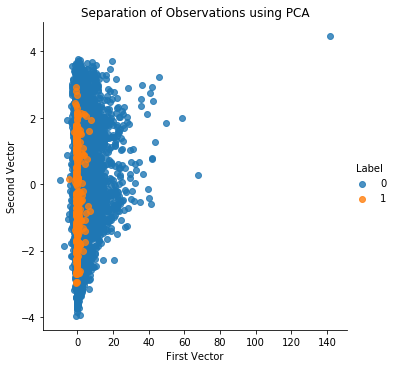

In [20]:
# 30 principal components
from sklearn.decomposition import PCA

n_components = 30

whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, \
                                   index=X_train.index)

scatterPlot(X_train_PCA, y_train, "PCA")

Let's calculate the precision-recall curve and the ROC curve.


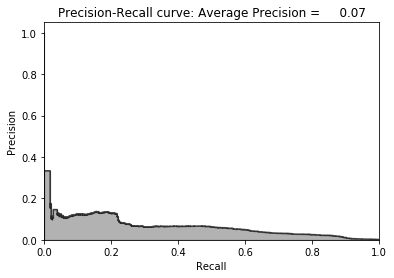

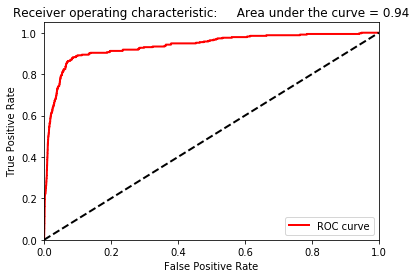

In [21]:
anomalyScoresPCA = anomalyScores(X_train, X_train_PCA_inverse)
preds = plotResults(y_train, anomalyScoresPCA, True)

With an average precision of 0.08, this is a poor fraud detection solution. It catches very little of the fraud.

### Search for the Optimal Number of Principal Components

The idea right now is to reduce the number of PCA and evaluate the fraud detection results.

According to the book the best configuration is 27 components.

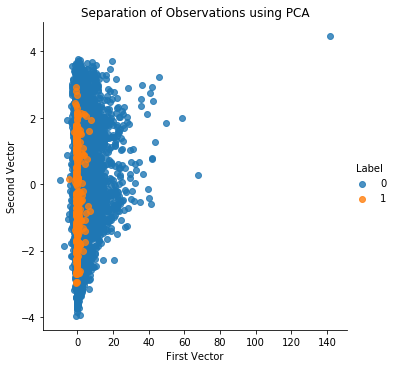

In [22]:
# 27 principal components
from sklearn.decomposition import PCA

n_components = 27
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, \
                                   index=X_train.index)

scatterPlot(X_train_PCA, y_train, "PCA")

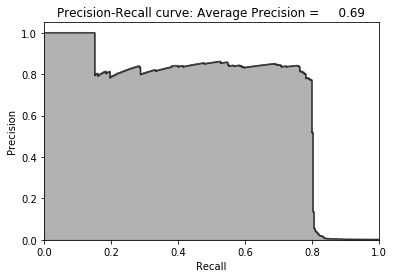

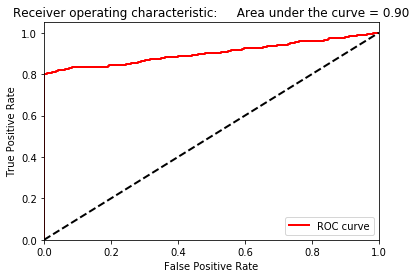

In [23]:
anomalyScoresPCA = anomalyScores(X_train, X_train_PCA_inverse)
preds = plotResults(y_train, anomalyScoresPCA, True)

Wow, look how the precision increases! *Result using normal PCA and 27 principal components*

### Sparse PCA Anomaly Detection

Sparse PCA is similar to normal PCA but delipers a less dense version, we still need to specify the number of principal components we desire, but we must also set the aplha parameter, which controls the degree of sparsity. 

/home/kuky/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/sparse_pca.py:170: DeprecationWarning: normalize_components=False is a backward-compatible setting that implements a non-standard definition of sparse PCA. This compatibility mode will be removed in 0.22.
  DeprecationWarning)


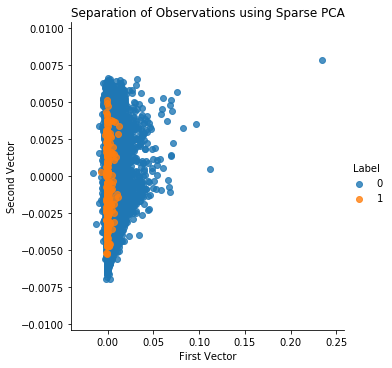

In [25]:
# Sparse PCA
from sklearn.decomposition import SparsePCA
n_components =  27
alpha = 0.0001
random_state = 2018
n_jobs = -1
sparsePCA = SparsePCA(n_components=n_components, alpha=alpha, random_state=random_state, n_jobs = n_jobs)
sparsePCA.fit(X_train)
X_train_sparsePCA = sparsePCA.transform(X_train)
X_train_sparsePCA = pd.DataFrame(data=X_train_sparsePCA, index=X_train.index)
scatterPlot(X_train_sparsePCA, y_train, "Sparse PCA")

In [28]:
print("shape of the training set {}".format(X_train.shape))
print("shape of the sparse set {}".format(X_train_sparsePCA.shape))

shape of the training set (190820, 30)
shape of the sparse set (190820, 27)


Now let's generate the originl dimensions from the sparse PCA matrix by simple matrix multiplication of the sparse PCA matrix. We also need to add the mean of each original feature to this new matrix. 

In [33]:
X_train_sparsePCA_inverse = np.array(X_train_sparsePCA).dot(sparsePCA.components_) + np.array(X_train.mean(axis=0))
X_train_sparsePCA_inverse = pd.DataFrame(data=X_train_sparsePCA_inverse, index=X_train.index)
X_train_sparsePCA_inverse.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
142087,-0.596636,-1.005945,1.156254,-0.137028,-0.241028,-0.358754,-0.090707,-0.217854,0.919084,-0.270209,...,0.233235,-0.222006,-0.683682,0.163298,-0.594361,-0.314125,0.213194,0.509139,0.451388,-0.356626
165168,0.646692,0.046099,0.685574,-0.137494,-0.350927,0.667460,-0.625366,0.795551,-0.126207,-0.167358,...,0.099470,-0.459884,-1.073228,0.139248,1.081781,-0.702981,0.230880,0.564507,0.263546,-0.306831
235908,1.572768,0.055506,-0.328768,-0.641341,-1.443025,-0.148061,-0.859313,1.172438,-0.547284,-2.742779,...,0.129379,0.581317,1.961918,0.520538,1.895371,-0.793212,0.219984,0.397749,0.820992,0.607285
148255,0.268998,-0.046231,0.550140,0.417943,-0.354334,0.238284,-0.751935,0.742747,-0.135727,-0.060411,...,-0.025414,-0.370806,-0.815106,0.105139,-0.020196,-0.830021,0.319331,0.620098,0.296733,-0.289130
145672,0.525746,-0.096097,0.554066,0.609053,-0.236586,0.617372,0.561391,0.170419,0.225278,-0.173143,...,0.144262,-0.245052,-0.601743,0.004232,-0.713169,-1.948158,-0.107843,0.591615,0.771743,-0.292685


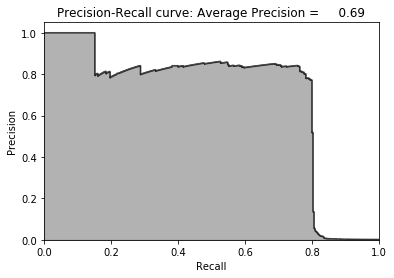

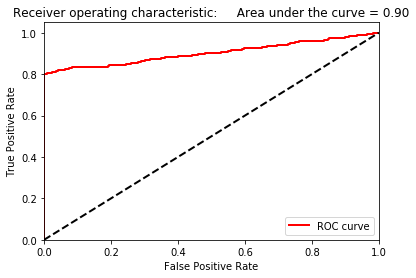

In [39]:
anomalyScoresSparsePCA = anomalyScores(X_train, X_train_sparsePCA_inverse)
preds = plotResults(y_train, anomalyScoresSparsePCA, True)

### Kernel PCA Anomaly Detection

This approach is a nonlinear form of PCA and is useful if the fraud transactions are not linearly separable from nonfraud transactions. We need to specify the number of of components we would like to generate, the kernel (in this case we are going to use the RBF Kernel), and gamma (which is set 1/n_features by default, so 1/30).

*Kernel PCA is too expensive to train with*, so we can get a set of the data in order to experiment and translate the results to the other data.

In [43]:
# Kernel PCA
from sklearn.decomposition import KernelPCA
n_components = 27
kernel = "rbf"
gamma = None
fit_inverse_transform = True
random_state = 2018
n_jobs = 1
kernelPCA = KernelPCA(n_components=n_components,kernel=kernel, gamma=gamma, 
                      fit_inverse_transform=fit_inverse_transform, random_state=random_state,
                      n_jobs=n_jobs)
kernelPCA.fit(X_train.iloc[:1000])

KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
          fit_inverse_transform=True, gamma=None, kernel='rbf',
          kernel_params=None, max_iter=None, n_components=27, n_jobs=1,
          random_state=2018, remove_zero_eig=False, tol=0)

In [49]:
X_train_kernelPCA = kernelPCA.transform(X_train)
X_train_kernelPCA = pd.DataFrame(data = X_train_kernelPCA, index= X_train.index)

MemoryError: 

page 107